In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
# adam = adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import cv2
from math import log10,sqrt
from PIL import Image
%matplotlib inline

In [79]:
'''
Data preparation
'''
csv_data = pd.read_csv('/Users/kuzaowuwei/Documents/GitHub/CDAE-C/data/preprocess/5-ROI_classify.csv')
csv_data = csv_data.iloc[:,:].values
print('csv_data.shape: ',csv_data.shape)
slice_num = 5
node_num = max(csv_data[:,1]) + 1
node_imgs = np.zeros((node_num, slice_num, 48, 48, 1))
node_labels = np.zeros((node_num, 1)).astype(int)
node_slice_count = np.zeros((node_num)).astype(int)
for i in range(len(csv_data)):
# for i in range(1):
    id = csv_data[i, 1]
    label = csv_data[i, 2]
    path = csv_data[i, 0]
    img = np.array(Image.open(path)).reshape(48,48,1)/ 255
    node_imgs[id,node_slice_count[id]] = img.copy()
    if node_slice_count[id] == 0:
        node_labels[id] = label
    node_slice_count[id] += 1
print('node_imgs.shape:',node_imgs.shape)
print('node_labels.shape:',node_labels.shape)

state = np.random.get_state()
np.random.shuffle(node_imgs)
np.random.set_state(state)
np.random.shuffle(node_labels)
# print(node_labels)
    # print(raw_img.shape)
    # raw_img = np.array(Image.open(path).resize((48,48),Image.LANCZOS))/ 255
loc=np.arange(node_num)
node_label_onehot=np.zeros((node_num,2))
node_labels=node_labels.reshape(node_num,)
node_label_onehot[loc,node_labels]=1

'''Split into 80% train and 20% test dataset'''
train_num = int(0.8*node_num)
test_num = node_num - train_num
node_train = node_imgs[:train_num] 
node_test = node_imgs[train_num:]
label_train = node_label_onehot[:train_num] 
label_test = node_label_onehot[train_num:] 
print('train scale:', node_train.shape, label_train.shape)
print('test scale:', node_test.shape, label_test.shape)

csv_data.shape:  (20, 3)
node_imgs.shape: (4, 5, 48, 48, 1)
node_labels.shape: (4, 1)
train scale: (3, 5, 48, 48, 1) (3, 2)
test scale: (1, 5, 48, 48, 1) (1, 2)


In [10]:
'''
Load Encoder from Pretrained Model
'''
encoder = load_model('../weights/encoder_model_1.h5')
encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, None, None, 1)]   0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, None, None, 128)   1280      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, None, None, 128)   0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, None, None, 64)    73792     
_________________________________________________________________
latent_code_layer (MaxPoolin (None, None, None, 64)    0         
Total params: 75,072
Trainable params: 75,072
Non-trainable params: 0
_________________________________________________________________


In [82]:
# latent_code_input = []
# for i in range(node_num):
#     latent_code = encoder.predict()
#     latent_code_input
def concatenate_latent_code(latent_code, slice_num=5):
    temp = latent_code[0]
    for i in range(slice_num-1):
        temp = np.concatenate((temp, latent_code[i+1]),axis=2)
    return temp
latent_code_train = np.zeros((train_num,12,12,320))
for id in range(train_num):
    # 5,12,12,64
    pred = encoder.predict(node_train[id])
    # 12,12,320
    pred_cat = concatenate_latent_code(pred)
    latent_code_train[id] = pred_cat
latent_code_test = np.zeros((test_num,12,12,320))
for id in range(test_num):
    # 5,12,12,64
    pred = encoder.predict(node_test[id])
    # 12,12,320
    pred_cat = concatenate_latent_code(pred)
    latent_code_test[id] = pred_cat


In [84]:
def CDAE_Classifier():
    sparsity=False
    if sparsity:
      reg = regularizers.l2(10e-5)
    else: 
      reg = None
    input_latent_code = Input(shape=(12,12,320),name='input_latent_code')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1',kernel_regularizer=reg)(input_latent_code)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    output_class = Dense(2,activation='sigmoid')(x)
    classifier = Model(inputs=input_latent_code,outputs=output_class)
    classifier.compile(optimizer='adam',loss='binary_crossentropy')
    return classifier
classifier = CDAE_Classifier()

In [ ]:
'''
Model Training
'''
# if GPU available
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    history = classifier.fit(latent_code_train, label_train, epochs=100, batch_size=10, validation_data=(latent_code_test, label_test), callbacks=[early_stopping,TensorBoard(log_dir=r"/data-output/CDAE",
                        histogram_freq=1,update_freq="batch")])

(12, 12, 320)


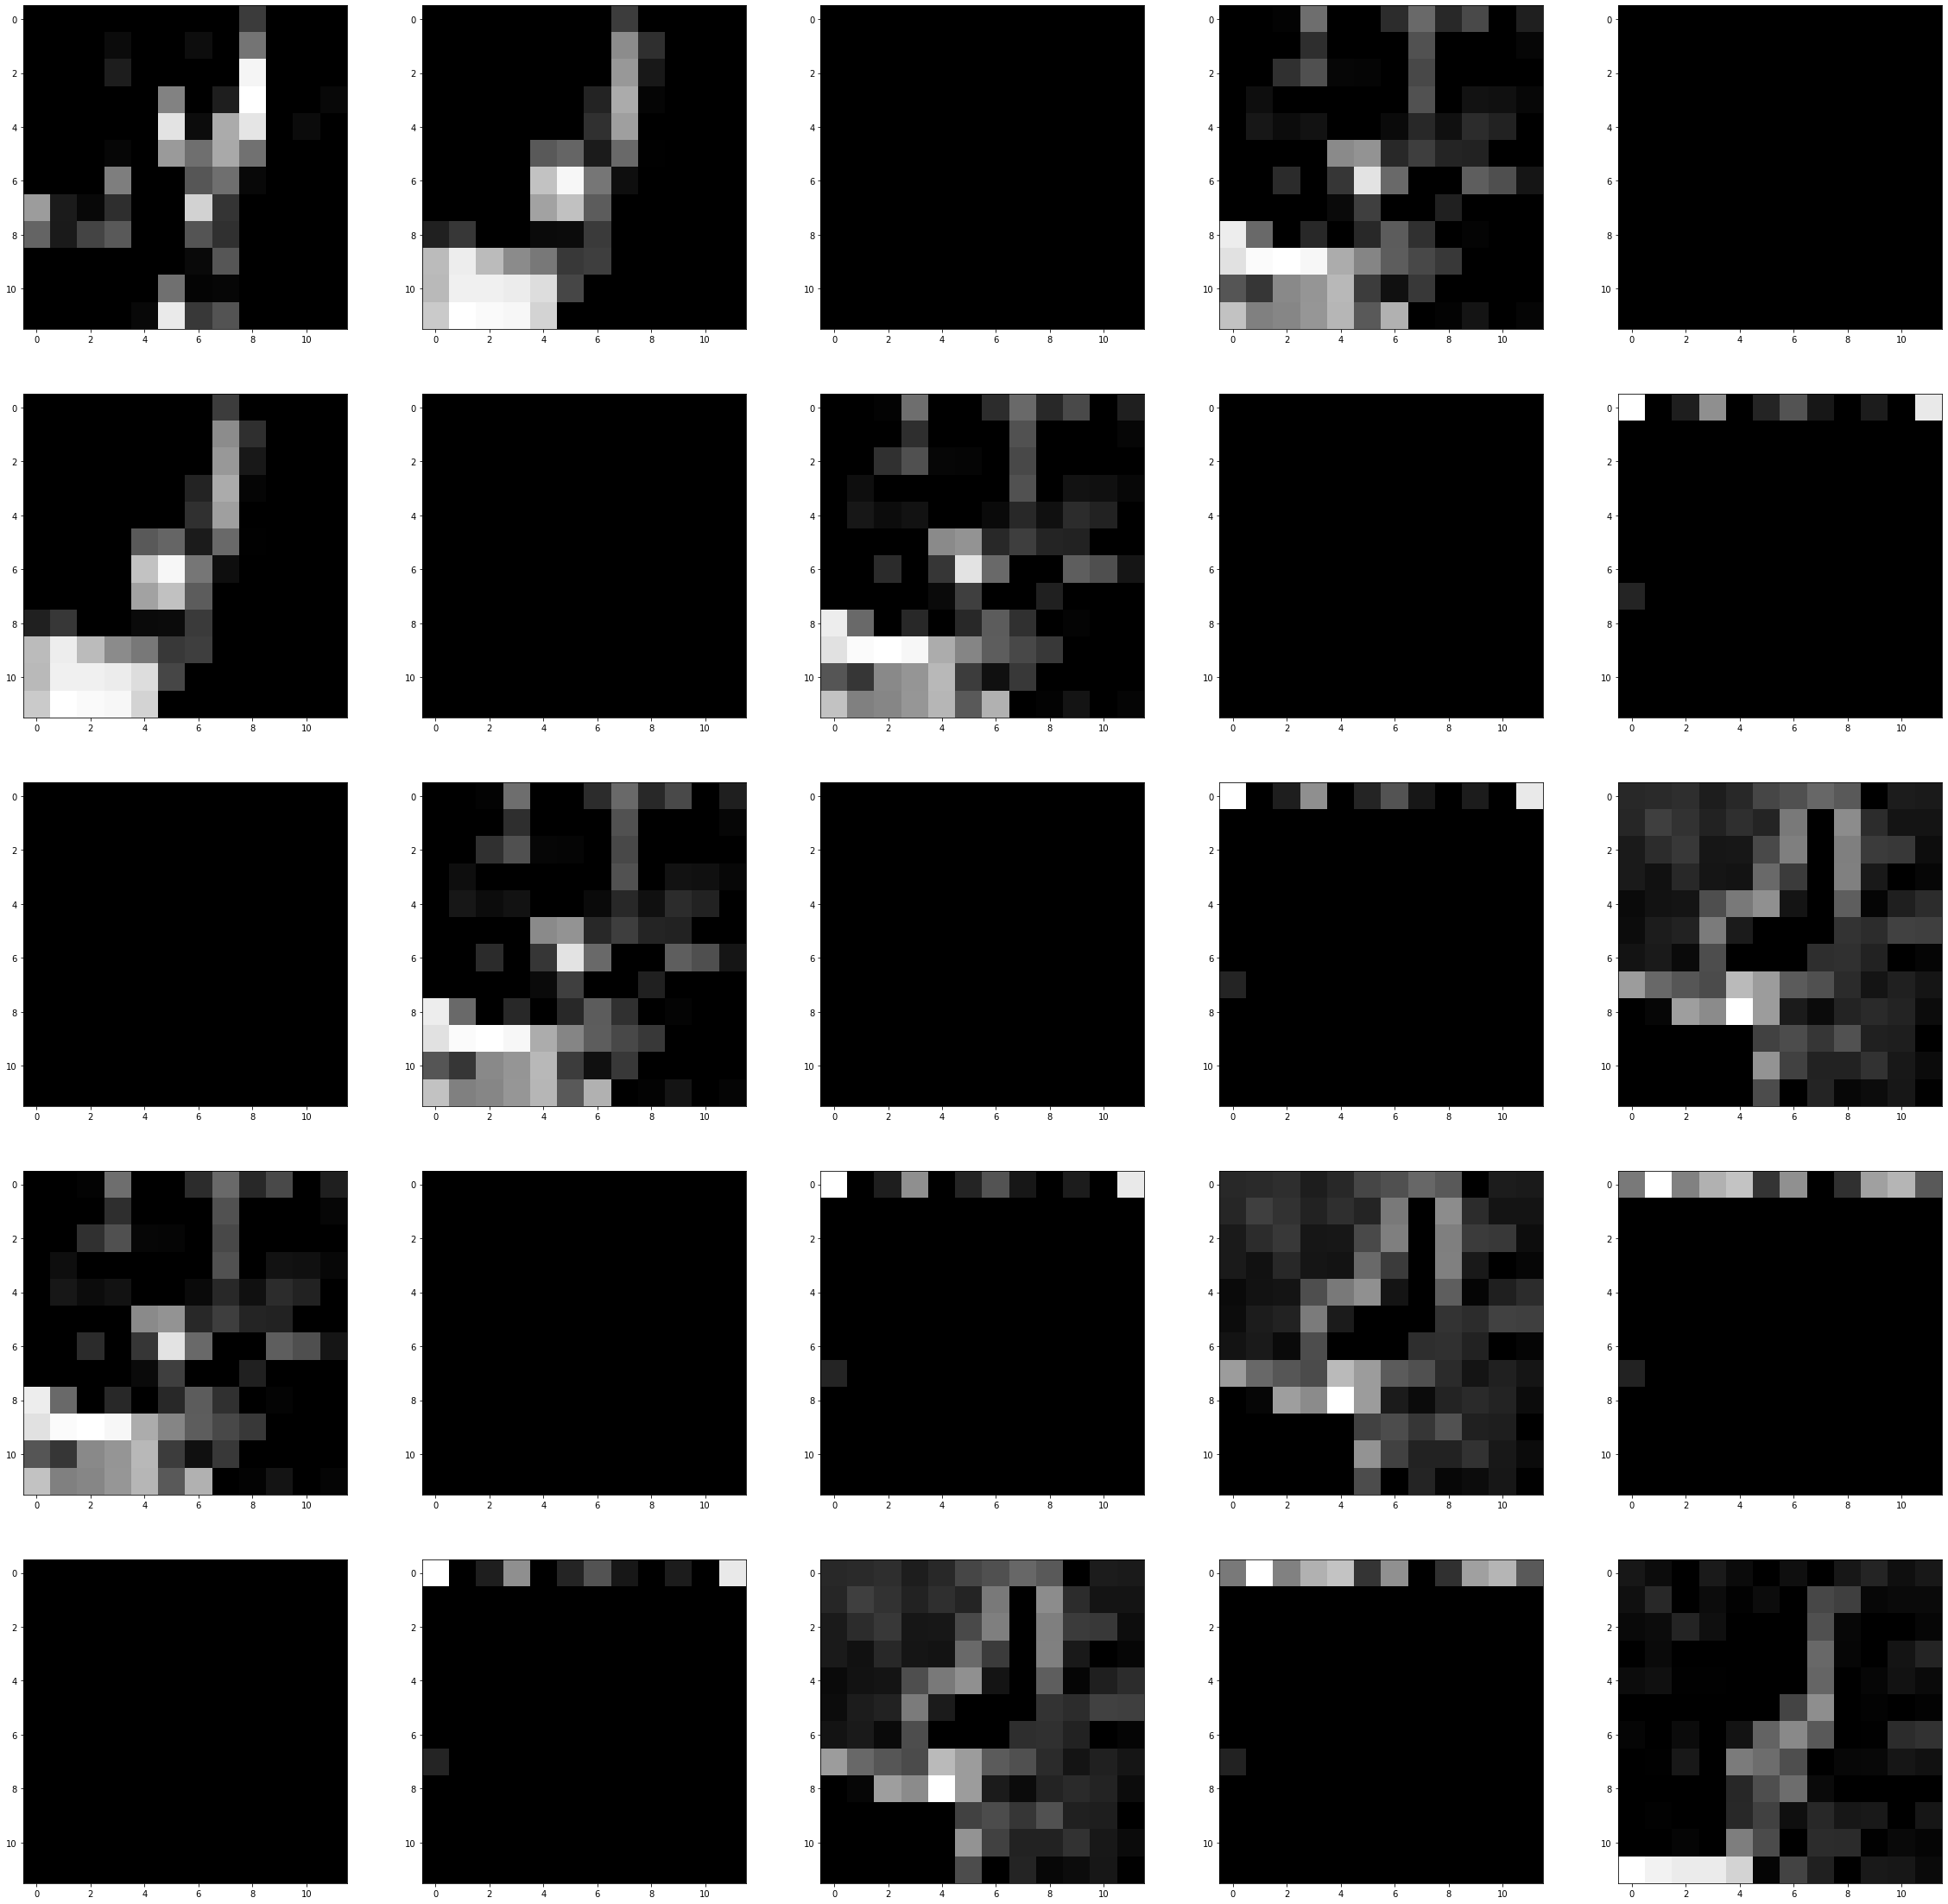

In [62]:
pred_cat = concatenate_latent_code(pred)
print(pred_cat.shape)
f,ax=plt.subplots(5,5)
f.set_size_inches(40,40)
for j in range(5):
    for i in range(5):
        ax[j][i].imshow(pred_cat[:,:,i+j+60],cmap='gray')
plt.show()
# plt.imshow(pred_cat[:,:,128].reshape(12,12))

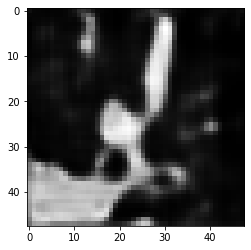

In [21]:
model = load_model('../weights/CDAE_model_1.h5')
plt.imshow(node_imgs[0][0].reshape(48,48),cmap='gray')
pred  = model.predict(node_imgs[0])
plt.imshow(pred[0].reshape(48,48),cmap='gray')

In [66]:
classifier = CDAE_Classifier()
pred_cat = concatenate_latent_code(pred).reshape(1,12,12,320)
print(pred_cat.shape)
pred_class = classifier.predict(pred_cat)
print(pred_class.shape)
print(pred_class)

(1, 12, 12, 320)
(1, 2)
[[0.47938016 0.4899865 ]]


In [73]:
loc=np.arange(5)
Y_train=np.zeros((5,2))
y_train=np.array([0,0,1,1,0])
Y_train[loc,y_train]=1
Y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])